In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pylab

In [2]:
plt.rcParams["font.size"] = 18
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
FIGURES_DIR = "figures/mlsys22"

## Simulator accuracy

In [4]:
def get_parallelism_style(dp, hp, pp):
    if dp == 1 and hp == 1 and pp == 1:
        return "Base"
    elif dp > 1 and hp == 1 and pp == 1:
        return "D"
    elif dp == 1 and hp > 1 and pp == 1:
        return "T"
    elif dp == 1 and hp == 1 and pp > 1:
        return "P"
    elif dp > 1 and hp > 1 and pp == 1:
        return "D/T"
    elif dp == 1 and hp > 1 and pp > 1:
        return "T/P"
    elif dp > 1 and hp == 1 and pp > 1:
        return "D/P"
    elif dp > 1 and hp > 1 and pp > 1:
        return "D/T/P"
    else:
        raise ValueError(f"Invalid degree combination dp={dp}, hp={hp}, pp={pp}")

In [5]:
def plot_simulator_accuracy(
    pytorch_filename,
    simulation_filename,
    x,
    y,
    xlabel,
    ylabel,
    xstep,
    ystep,
    output_filename,
    legend_output_filename=None,
):
    df = pd.read_csv(pytorch_filename)
    df_simulation = pd.read_csv(simulation_filename)
    df = df.rename(
        columns={"latency": "pytorch_latency", "throughput": "pytorch_throughput"}
    )
    df["simulated_latency"] = df_simulation["latency"]
    df["simulated_throughput"] = df_simulation["throughput"]
    parallelism_styles = [
        get_parallelism_style(dp, hp, pp)
        for (dp, hp, pp) in df[["dp_degree", "hp_degree", "pp_degree"]].values
    ]
    df["parallelism_style"] = parallelism_styles
    markers = ["o", "P", "^", "*", "X", "D", "H", "s"]
    colors = [
        "#7f7f7f",  # middle gray
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
        "#9467bd",  # muted purple
        "#8c564b",  # chestnut brown
        "#e377c2",  # raspberry yogurt pink
        # "#bcbd22",  # curry yellow-green
        # "#17becf",  # blue-teal
    ]
    parallelism_styles = [
        "Base",
        "D",
        "T",
        "P",
        "D/T",
        "T/P",
        "D/P",
        "D/T/P",
    ]
    lines = []
    fig = pylab.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    figlegend = pylab.figure(figsize=(5, 1))
    for (parallelism_style, marker, color) in zip(parallelism_styles, markers, colors):
        lines.append(
            ax.scatter(
                df[df["parallelism_style"] == parallelism_style][x],
                df[df["parallelism_style"] == parallelism_style][y],
                label=parallelism_style,
                marker=marker,
                color=color,
                s=100,
                zorder=3
            )
        )
    min_val = min(min(df[x]), min(df[y]))
    max_val = max(max(df[x]), max(df[y]))
    ax.plot(
        [min_val, max_val],
        [min_val, max_val],
        linestyle="--",
        color="black",
        zorder=2,
    )
    #     ax.set_yticks(np.arange(0, max(df[y]) + ystep, ystep))
    xticks = np.arange(0, max(df[x]) + xstep, xstep)
    yticks = np.arange(0, max(df[x]) + ystep, ystep)
    ax.set_xticks(xticks)
    ax.set_xticklabels([str(int(t)) for t in xticks])
    ax.set_yticks(yticks)
    ax.set_yticklabels([str(int(t)) for t in yticks])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.grid(zorder=0)
    leg = figlegend.legend(
        lines,
        parallelism_styles,
        frameon=False,
        loc="center",
        ncol=4,
        columnspacing=None,
        labelspacing=None,
    )
    fig.savefig(output_filename, bbox_inches="tight")
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")
    # Get the bounding box of the original legend.


#     bb = leg.get_bbox_to_anchor().transformed(plt.gca().transAxes.inverted())

#     # Change to location of the legend.
#     yOffset = 1.2
#     bb.y0 += yOffset
#     bb.y1 += yOffset
#     leg.set_bbox_to_anchor(bb, transform=plt.gca().transAxes)
#     leg.get_frame().set_linewidth(0.0)

### MLP Training

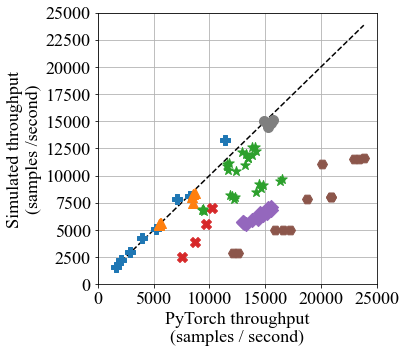

<Figure size 360x72 with 0 Axes>

In [6]:
simulation_filename = "~/Downloads/mlp_grid_search_results_simulation_v100.csv"
pytorch_filename = "~/Downloads/mlp_grid_search_results_pytorch_v100.csv"
plot_simulator_accuracy(
    pytorch_filename,
    simulation_filename,
    "pytorch_throughput",
    "simulated_throughput",
    "PyTorch throughput\n(samples / second)",
    "Simulated throughput\n(samples /second)",
    5000,
    2500,
    os.path.join(FIGURES_DIR, "mlp_training_pytorch_vs_simulated_throughput.pdf"),
    os.path.join(FIGURES_DIR, "pytorch_vs_simulated_throughput_legend.pdf"),
)

### GPT-2 Inference

### TODO

## Optimal configurations

In [7]:
def plot_optimal_configurations(
    pytorch_filename,
    all_model_sizes,
    metric,
    output_filename,
    legend_output_filename=None,
):
    def get_data(model_size):
        if metric == "throughput":
            sort_fn = max
        elif metric == "latency":
            sort_fn = min
        df = pd.read_csv(pytorch_filename)
        # df = df[df["model_size"] == model_size]
        df = df[
            df["model_size"] == all_model_sizes[0]
        ]  # TODO: Fix this, only for demonstration purposes
        df = df.sort_values(by=["throughput"], ascending=False)
        data = [
            sort_fn(
                df[
                    (df["dp_degree"] == 1)
                    & (df["hp_degree"] == 1)
                    & (df["pp_degree"] == 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    (df["dp_degree"] > 1)
                    & (df["hp_degree"] == 1)
                    & (df["pp_degree"] == 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    (df["dp_degree"] == 1)
                    & (df["hp_degree"] > 1)
                    & (df["pp_degree"] == 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    (df["dp_degree"] == 1)
                    & (df["hp_degree"] == 1)
                    & (df["pp_degree"] > 1)
                ][metric].values
            ),
            sort_fn(
                df[
                    ((df["dp_degree"] > 1) & (df["hp_degree"] > 1))
                    | ((df["dp_degree"] > 1) & (df["pp_degree"] > 1))
                    | ((df["hp_degree"] > 1) & (df["pp_degree"] > 1))
                ][metric].values
            ),
        ]
        base = data[0]
        if metric == "throughput":
            data = [v / base for v in data[1:]]
        elif metric == "latency":
            data = [base / v for v in data[1:]]
        return data

    fig = pylab.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    figlegend = pylab.figure(figsize=(5, 1))
    width = 0.65 / len(all_model_sizes)
    if len(all_model_sizes) > 1:
        offsets = np.arange(
            -1 * width, 4 * width, width
        )  # TODO: Fix for even number of model sizes
    else:
        offsets = [0]
    patterns = ["/", "x", "+"]
    lines = []
    max_val = -1
    for i, model_size in enumerate(all_model_sizes):
        data = get_data(model_size)
        x = np.array(list(range(len(data)))) + offsets[i]
        if i == 0:
            lines.append(
                ax.bar(x, height=data, width=width, label=model_size, zorder=3)
            )
        else:
            lines.append(
                ax.bar(
                    x,
                    height=data,
                    width=width,
                    label=model_size,
                    hatch=patterns[i - 1],
                    zorder=3,
                )
            )
        max_val = max(max(data), max_val)
    #         for j in range(len(data)):
    #             plt.text(j+offsets[i], data[j] + 0.05 * data[0], f"{data[j]:.2f}.x", ha="center")
    ax.set_xticks(ticks=np.array(list(range(len(data)))))
    ax.set_xticklabels(["D", "T", "P", "Hybrid"])
    ax.set_xlabel("Configuration")
    ax.set_ylabel("Speedup")
    ax.set_ylim(0, 1.2 * max_val)
    spines = list(ax.spines.keys())
    ax.spines[spines[1]].set_visible(False)
    ax.spines[spines[3]].set_visible(False)
    leg = figlegend.legend(
        lines,
        all_model_sizes,
        frameon=False,
        loc="center",
        ncol=4,
        columnspacing=None,
        labelspacing=None,
    )
    ax.grid(zorder=0)
    fig.savefig(output_filename, bbox_inches="tight")
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")

### MLP Training

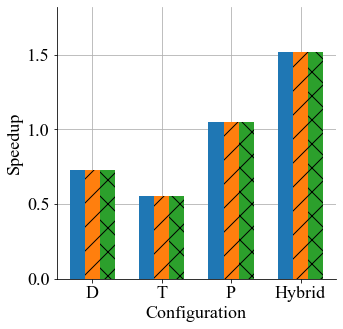

<Figure size 360x72 with 0 Axes>

In [8]:
pytorch_filename = "~/Downloads/mlp_grid_search_results_pytorch_v100.csv"
plot_optimal_configurations(
    pytorch_filename,
    ["mlp-xs", "mlp-small", "mlp-medium"],
    "throughput",
    os.path.join(FIGURES_DIR, "mlp_training_optimal_configurations.pdf"),
    os.path.join(FIGURES_DIR, "mlp_training_optimal_configurations_legend.pdf"),
)

### GPT-2 Inference

### TODO

## Memory usage vs throughput / latency

In [11]:
def plot_memory_usage_vs_metric(
    simulation_filename, metric, xlabel, ylabel, output_filename, legend_output_filename=None
):
    df = pd.read_csv(simulation_filename)
    parallelism_styles = [
        get_parallelism_style(dp, hp, pp)
        for (dp, hp, pp) in df[["dp_degree", "hp_degree", "pp_degree"]].values
    ]
    df["parallelism_style"] = parallelism_styles
    markers = ["o", "P", "^", "*", "X", "D", "H", "s"]
    colors = [
        "#7f7f7f",  # middle gray
        "#1f77b4",  # muted blue
        "#ff7f0e",  # safety orange
        "#2ca02c",  # cooked asparagus green
        "#d62728",  # brick red
        "#9467bd",  # muted purple
        "#8c564b",  # chestnut brown
        "#e377c2",  # raspberry yogurt pink
        # "#bcbd22",  # curry yellow-green
        # "#17becf",  # blue-teal
    ]
    parallelism_styles = [
        "Base",
        "D",
        "T",
        "P",
        "D/T",
        "T/P",
        "D/P",
        "D/T/P",
    ]
    lines = []
    fig = pylab.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)
    figlegend = pylab.figure(figsize=(5, 1))
    for (parallelism_style, marker, color) in zip(parallelism_styles, markers, colors):
        lines.append(
            ax.scatter(
                df[df["parallelism_style"] == parallelism_style][metric],
                df[df["parallelism_style"] == parallelism_style]["peak_memory"] / 1e9,
                label=parallelism_style,
                marker=marker,
                color=color,
                s=200,
                zorder=3,
            )
        )
    ax.grid(zorder=0)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    fig.tight_layout()
    fig.savefig(output_filename, bbox_inches="tight")
    leg = figlegend.legend(
        lines,
        parallelism_styles,
        frameon=False,
        loc="center",
        ncol=8,
        columnspacing=None,
        labelspacing=None,
    )
    if legend_output_filename is not None:
        figlegend.savefig(legend_output_filename, bbox_inches="tight")

### MLP Training

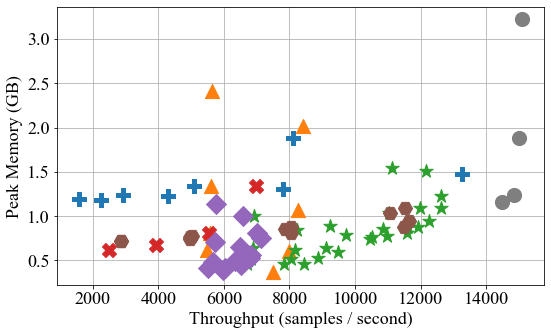

<Figure size 360x72 with 0 Axes>

In [12]:
simulation_filename = "~/Downloads/mlp_grid_search_results_simulation_v100.csv"
plot_memory_usage_vs_metric(
    simulation_filename,
    "throughput",
    "Throughput (samples / second)",
    "Peak Memory (GB)",
    os.path.join(FIGURES_DIR, "mlp_training_memory_vs_throughput.pdf"),
    os.path.join(FIGURES_DIR, "mlp_training_memory_vs_throughput_legend.pdf"),
)

### GPT-2 Inference

### TODO